<font size=6><b>Предсказание заказов такси</b></font>

# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Подготовка данных

In [1]:
# подключаем все необходимые библиотеки
import os

import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from scipy.signal import periodogram

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
# задаем стили и размер графиков
sns.set(style='darkgrid', rc={'figure.figsize': (8, 4)})

In [3]:
# путь до файла
file_path = '/datasets/taxi.csv'

# учитываем разницу путей на сервере и на локальном компьютере
if not os.path.exists(file_path):
    file_path = f'.{file_path}'

In [4]:
# загружаем датасет
taxi_df = pd.read_csv(file_path, parse_dates=[0], index_col=[0])

In [5]:
# знакомимся с данными
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
print('Даты отсортированы в порядке возрастания:', taxi_df.index.is_monotonic_increasing)

Даты отсортированы в порядке возрастания: True


In [7]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Нам представлены данные о количестве заказов в промежутках 10 минут с начала марта 2018 года по конец августа 2018 года. В датасете нет пропусков. 

In [8]:
# проведем ресемплирование данных, чтобы промежуток был не 10 минут а 1 час
taxi_df = taxi_df.resample('1H').sum()

In [9]:
# разделим данные на обучающие и тестовые
train_df, test_df = train_test_split(taxi_df, shuffle=False, test_size=0.1)

In [10]:
# посмотрим, какие диапазоны попали в датасеты
print(f'Диапазон обучающих данных: от {train_df.index.date.min()} до {train_df.index.date.max()}')
print(f'Диапазон тестовых данных: от {test_df.index.date.min()} до {test_df.index.date.max()}')

Диапазон обучающих данных: от 2018-03-01 до 2018-08-13
Диапазон тестовых данных: от 2018-08-13 до 2018-08-31


# Анализ данных

Проводим анализ только обучающих данных, поскольку о будущем (о тестовых данных) мы, по идее, ничего не знаем.

In [11]:
# проведем декомпозицию по сезонным трендам с помощью LOESS, здесь возьмем только первую неделю
decomposed_hour = STL(train_df['2018-03-21':'2018-03-27'].num_orders).fit()

In [12]:
# построим графики для вычисленных компонент
def plot_seasonal_decompostion(decomposition, title):
    names = ['trend', 'seasonal', 'resid']

    fig = make_subplots(3, 1, subplot_titles=[name.capitalize() for name in names],
                        x_title='Datetime',
                        y_title='Counts',
                        horizontal_spacing = 0.1,
                        vertical_spacing=0.1)
    row = col = 1

    for param in names:
        data = decomposition.__getattribute__(param)
        fig.add_trace(go.Scatter(x=data.index, y=data.values, name=param, 
                                 hovertemplate='%{x|%Y-%m-%d %H:00<br>weekday: %w}<br>orders: %{y:.0f}'), 
                      row=row, col=col)
        row += 1

    fig.update_layout(height=1200, width=1000, title=f'Seasonal decomposition. {title}')
    fig.show(renderer='svg')

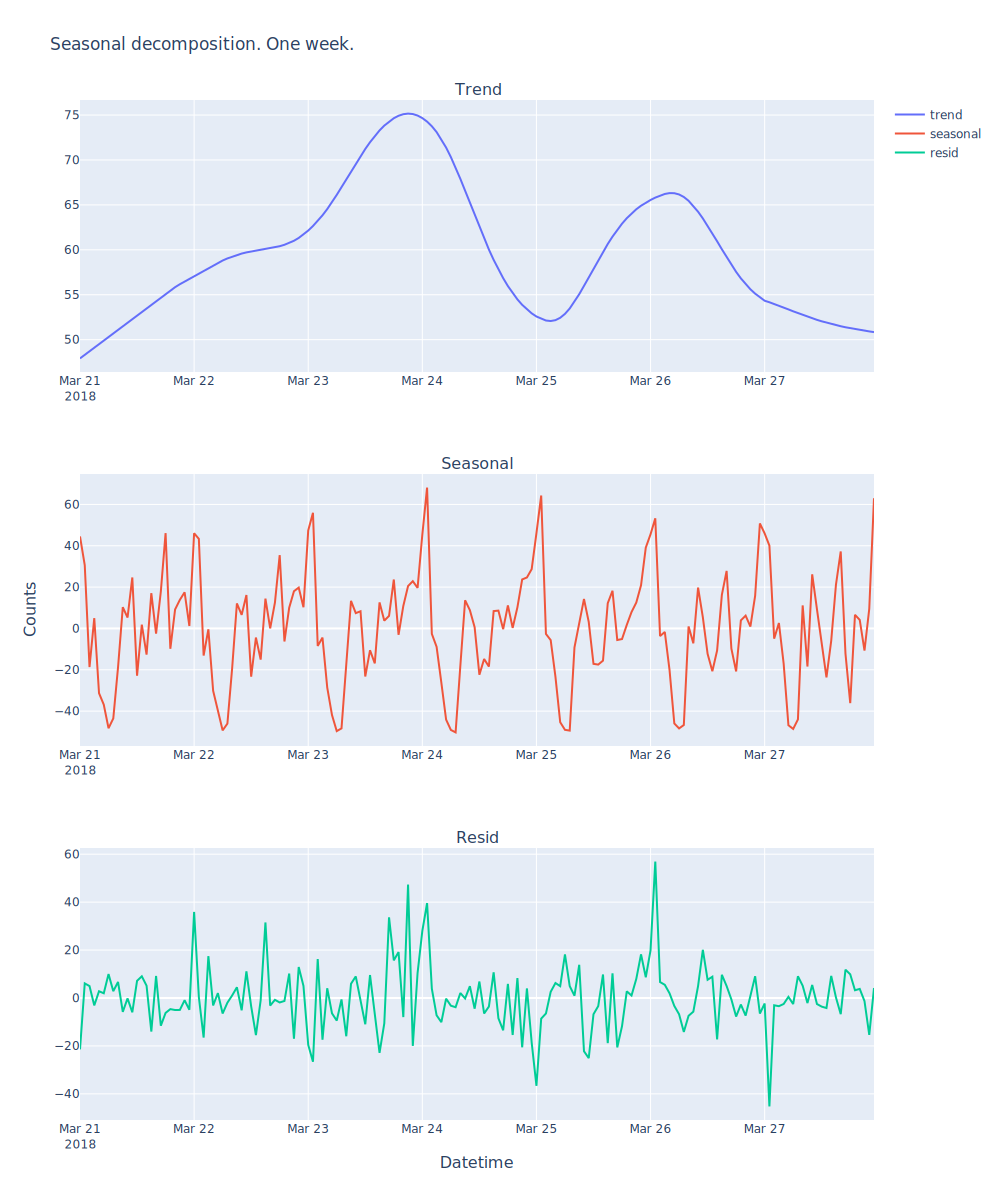

In [13]:
plot_seasonal_decompostion(decomposed_hour, 'One week.')

In [14]:
# рассмотрим данные, ресемплированные по дням
decomposed_day = STL(train_df.resample('1D').sum().num_orders).fit()

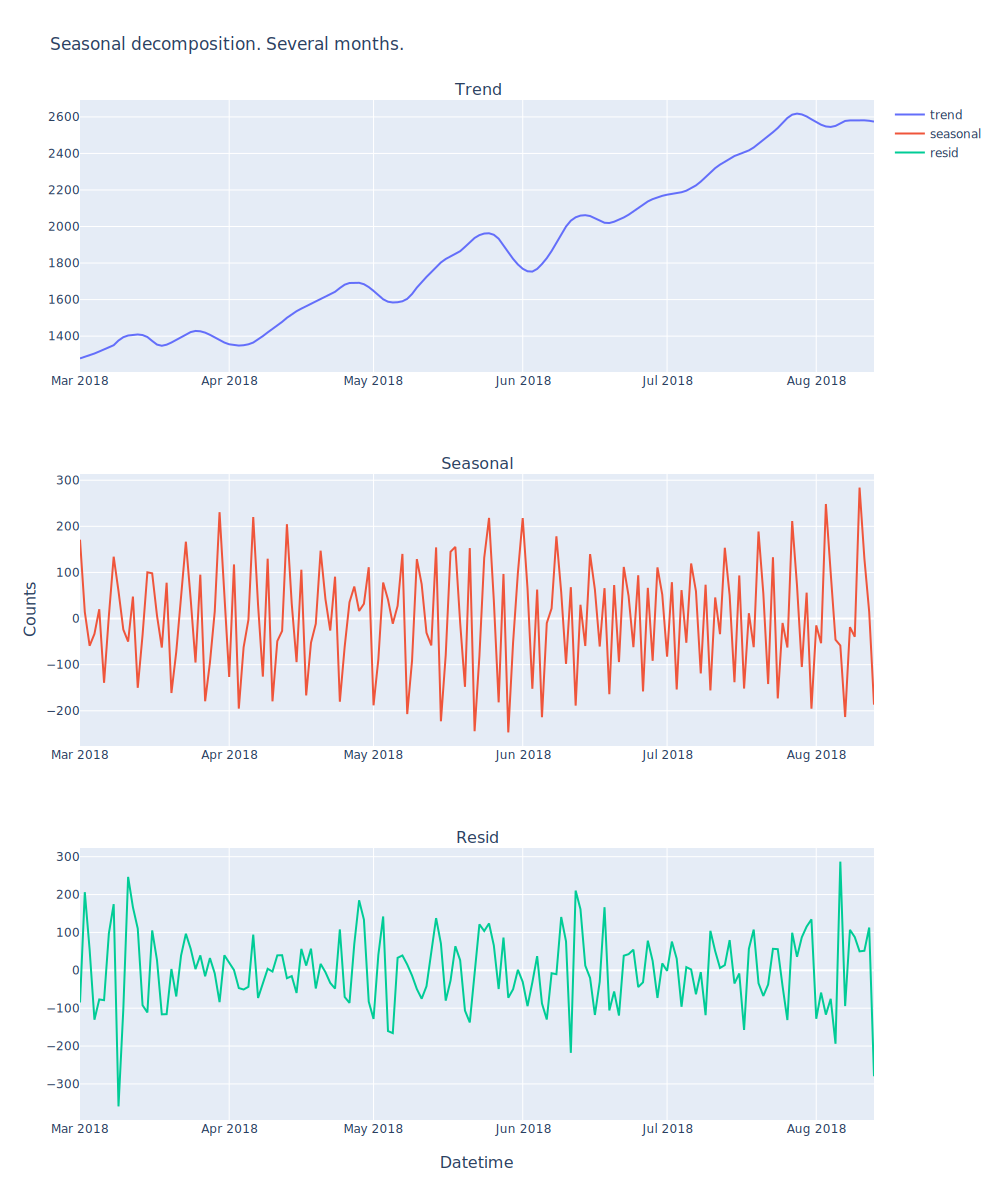

In [15]:
plot_seasonal_decompostion(decomposed_day, 'Several months.')

График компоненты тренда явно возрастает от месяца к месяцу, что говорит о том, что со временем число заказов в час увеличивается. 

В графике сезонной компоненты можно выделить явные дневной и недельный паттерн.<br>
*Дневной паттерн*: с 6:00 до 12:00 число заказов в час увеличивается, затем идет спад вплоть до 6:00.<br>
*Недельный паттерн*: в субботу приходит больше всего заказов, их количество постепенно уменьшается вплоть до понедельника, во вторник происходит скачок заказов, в среду их наименьшее количество, затем в четверг и пятницу они снова возрастают и достигают пика в субботу. В зависимости от месяца наблюдается попеременное увеличение и уменьшение сезонной разности в количестве заказов в день.

Из графика компоненты остатков можно заключить, что со временем объем шума в данных практически не изменяется.

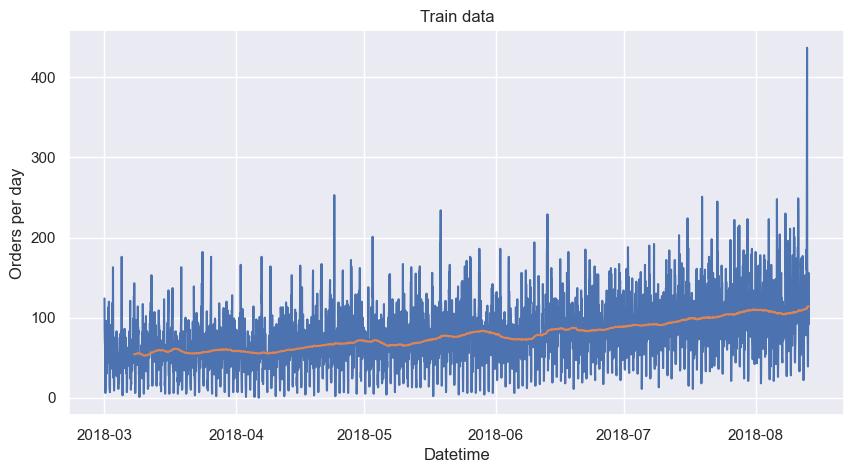

In [16]:
# построим исходный и сглаженный ряд. чтобы не было мешанины линий ограничимся только последними 1000 точками
plot_df = train_df.iloc[:, 0]

plt.figure(figsize=(10, 5))

plt.plot(plot_df)
plt.plot(plot_df.rolling(24 * 7).mean())

plt.title('Train data')
plt.xlabel('Datetime')
plt.ylabel('Orders per day')

plt.show()

По определению *стационарный ряд* - это ряд, у которого среднее и стандартное отклонение не изменяются. Исходя из анализа сглаженного ряда, ряд может быть не стационарен (тренд растет), однако это маловероятно. Более точно это можно проверить с применением теста Дики-Фуллера (ADF). 

Проверим следующие гипотезы:

$H_0$: Временной ряд не стационарен<br>
$H_1$: Временной ряд стационарен

In [17]:
results = adfuller(train_df.num_orders)

print(f'Критерий ADF: {results[0]:.2f}')
print(f'p-value: {results[1]*100:.2f}%')

if results[0] < results[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -4.17
p-value: 0.07%
Нулевая гипотеза отвергнута – Временной ряд стационарен


Наше предположение подтверждено.

Попробуем определить частоты сезонной компоненты.

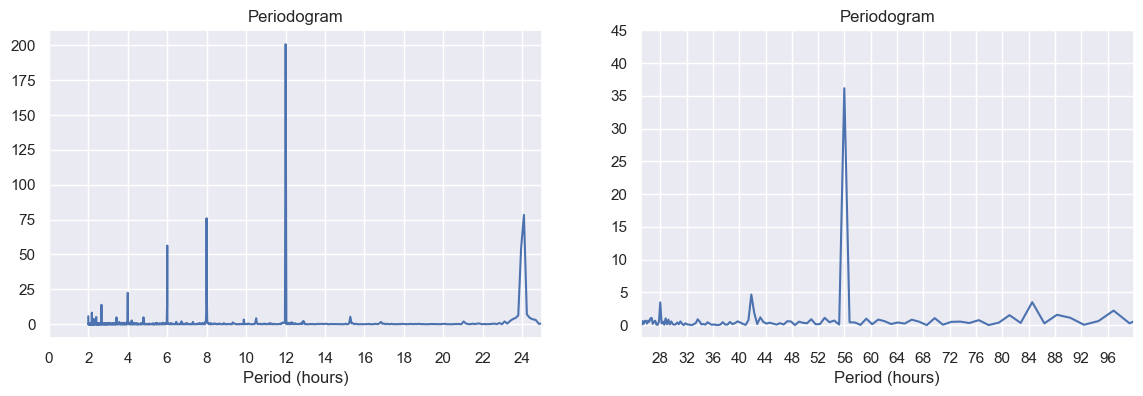

In [18]:
# связь Герц с одним обратным часом
rev_hour = 1 / 60 / 60

# проводим разложение в рад Фурье и определяем амплитуды для каждой из частот
freq, psd = periodogram(train_df.num_orders, fs=rev_hour, window='boxcar',  scaling='spectrum')

# удаляем из рассмотрения нулевую частоту, переводим частоту в период
freq = 1 / freq[1:] / 60 / 60
psd = psd[1:]

# строим два графика: период от 0 до 25 и от 25 до 100
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Periodogram')
plt.plot(freq, psd)
plt.xticks(range(0, 25, 2))
plt.xlim([0, 25])
plt.xlabel('Period (hours)')

plt.subplot(1, 2, 2)
plt.title('Periodogram')
plt.plot(freq, psd)
plt.xticks(range(24, 100, 4))
plt.yticks(range(0, 51, 5))
plt.xlim([25, 100])
plt.ylim([-2, 45])
plt.xlabel('Period (hours)')

plt.show()

Сезонная компонента раскладывается на состовляющие с периодами 4, 6, 8, 12, 24 и 56 часов.

# Обучение моделей

In [19]:
# функция для создания новых фичей
def make_features(df, rol=12):
    df = df.copy()
    
    df['hour'] = df.index.hour.astype('category')
    df['day'] = df.index.day.astype('category')                  # день месяца
    df['day_of_week'] = df.index.day_of_week.astype('category')  # день недели 
    
    df[f'trend_half_day'] = df.num_orders.shift(1).rolling(12).mean()    # среднее количество заказов за 12 часов
    df[f'trend_daily'] = df.num_orders.shift(1).rolling(24).mean()       # среднее количество заказов за 24 часа
    df[f'trend_weekly'] = df.num_orders.shift(1).rolling(168).mean()     # среднее количество заказов за неделю
        
    for i in [1, 4, 6, 8, 12, 24, 56]:
        df[f'diff_{i}'] = df.num_orders.shift(1) - df.num_orders.shift(i + 1).rolling(i).mean() 
        
    return df

In [20]:
# создадим новые фичи
taxi_df = make_features(taxi_df)

# разделим данные на обучающие и тестовые
train_df, test_df = train_test_split(taxi_df, shuffle=False, test_size=0.1)
train_df = train_df.dropna()

In [21]:
# в датафрейм будем записывать результаты RMSE обученных моделей
fit_results = pd.DataFrame(columns=['RMSE'])

In [22]:
# разделим данные на признаки и таргет
X_train = train_df.drop('num_orders', axis=1)
y_train = train_df.num_orders

X_test = test_df.drop('num_orders', axis=1)
y_test = test_df.num_orders

In [23]:
# функция для сравнения предсказания с реальными данными
def plot_predict(x, y_true, y_pred, title):
    plt.plot(x, y_true, label='True')
    plt.plot(x, y_pred, label='Predict')
    
    
    plt.legend()
    plt.title(title)
    plt.xlabel('Datetime')
    plt.xticks(rotation=45)
    plt.ylabel('Orders per hour')
    
    plt.show()

In [24]:
def get_regressor_name(regressor):
    if isinstance(regressor, GridSearchCV):
        reg_name = regressor.estimator
        if isinstance(reg_name, Pipeline):
            reg_name = regressor.estimator.named_steps['regressor']
    else:
        reg_name = regressor
        
    return reg_name.__class__.__name__

In [25]:
# создадим функцию для обучения модели и вывода основных результатов обучения
def train_model(model, grid_params, X, y, nsplits=4, points=250):
    gs_cv = GridSearchCV(
        model,
        grid_params,
        scoring='neg_root_mean_squared_error',
        cv=TimeSeriesSplit(nsplits),
        n_jobs=-1,
        verbose=1
    )
    
    gs_cv.fit(X, y)
    
    reg_name = get_regressor_name(gs_cv)
        
    
    print(f'Best train RMSE: {-gs_cv.best_score_:.2f}')
    fit_results.loc[reg_name] = -gs_cv.best_score_
    
    if gs_cv.best_params_:
        print('\nBest parameters:')
        for key, val in gs_cv.best_params_.items():
            print(f'{key}: {val}')
    
    x = X.index[-points:]
    plot_predict(x, y[-points:], gs_cv.predict(X_train)[-points:], reg_name)
    
    return gs_cv

In [26]:
# закодируем категориальные признаки с помощью one-hot векторов
linear_pipeline = Pipeline([
    ('transformer', 
     ColumnTransformer([
        ('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), X_train.columns[:3]),
    ], remainder='passthrough')
    ),
    ('regressor', None)
])

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best train RMSE: 29.00


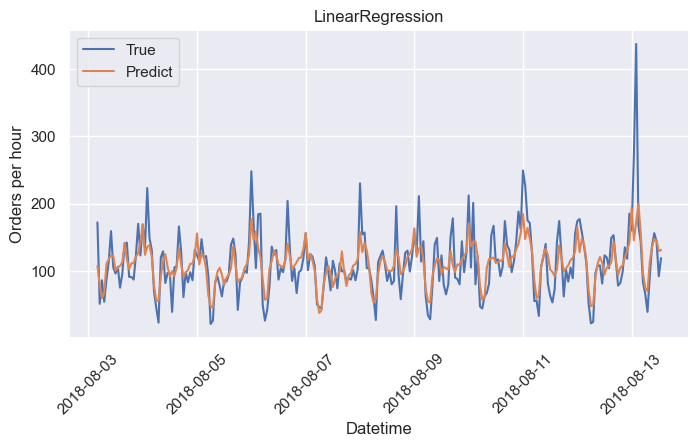

In [27]:
# обучим простую линейную регрессию
linear_pipeline.set_params(regressor=LinearRegression())
linreg = train_model(linear_pipeline, {}, X_train, y_train)

In [28]:
np.random.seed = 42

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best train RMSE: 27.74

Best parameters:
regressor__alpha: 1


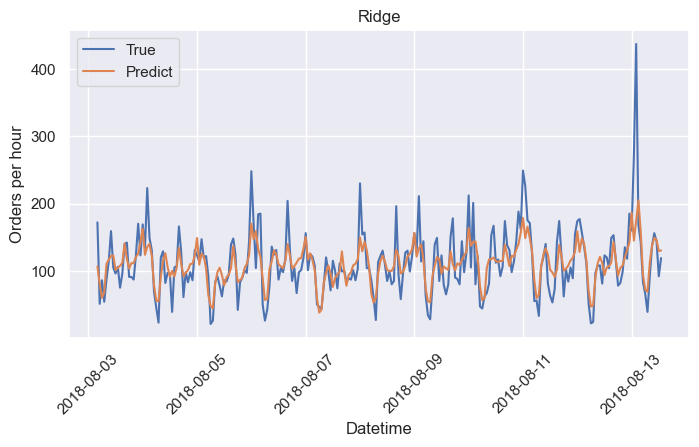

In [29]:
# обучим Ridge
linear_pipeline.set_params(regressor=Ridge(random_state=42))
ridge = train_model(linear_pipeline, {'regressor__alpha': [0.001, 0.01, 0.1, 1]}, X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best train RMSE: 26.54


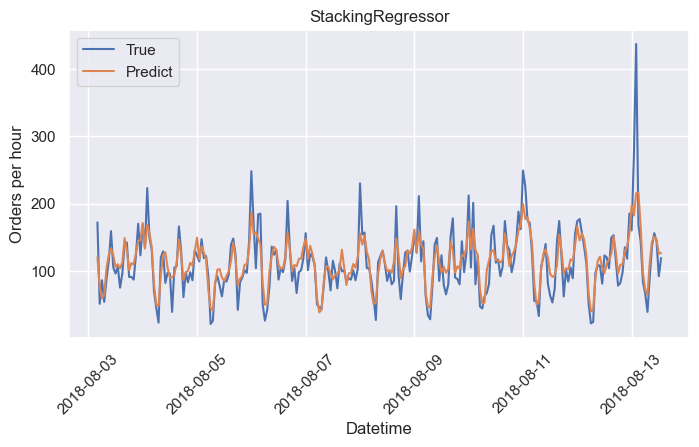

In [30]:
# поскольку деревянные модели часто переобучаются, попробуем объединить градиентный бустинг 
# с Ridge в стэкинг
linear_pipeline.set_params(regressor=StackingRegressor(estimators=[
                                                            ('lgbm', LGBMRegressor(random_state=42)),                         
                                                            ('ridge', Ridge(random_state=42)),
                                                        ], 
                                                       final_estimator=Ridge(random_state=42)))
stack_ridge = train_model(linear_pipeline, {}, X_train, y_train)

Best train RMSE: 26.41


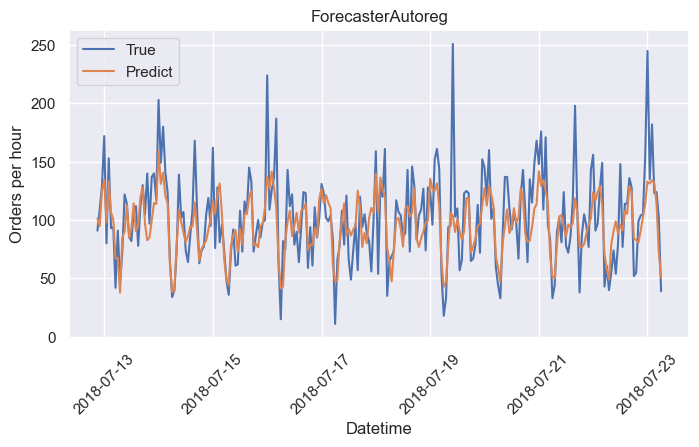

In [31]:
# попробуем авторегрессор из skforecast
rmse = []

# добавим в качестве регрессора StackingRegressor
forecaster = ForecasterAutoreg(regressor=StackingRegressor(estimators=[
                                                        ('lgbm', LGBMRegressor(random_state=101)),                         
                                                        ('ridge', Ridge(random_state=42)),
                                                    ], 
                                                   final_estimator=Ridge(random_state=42)), lags=192)

# кросс-валидация 
for train_idx, valid_idx in TimeSeriesSplit(n_splits=4).split(y_train):
    
    # делим на обучающую и валидационную выборки
    y_train_cv = y_train[train_idx]
    y_valid_cv = y_train[valid_idx]

    forecaster.fit(y_train_cv)
    rmse.append(mean_squared_error(forecaster.predict(steps=y_valid_cv.shape[0]), y_valid_cv, squared=False))

best_rmse = min(rmse)
fit_results.loc['ForecasterAutoreg'] = best_rmse
print(f'Best train RMSE: {best_rmse:.2f}')

plot_predict(y_valid_cv[:250].index, y_valid_cv[:250], forecaster.predict(steps=250), 'ForecasterAutoreg')

In [32]:
models = {
    'LinearRegression': linreg, 
    'Ridge': ridge, 
    'StackingRegressor': stack_ridge, 
    'ForecasterAutoreg': forecaster
}

# определяем лучшую модель
best_model_name = fit_results.idxmin().values[0]
best_model = models[best_model_name]

# выводим таблицу с данными RMSE и название лучшей модели
display(fit_results)
print('Лучшая модель по RMSE на кросс-валидации:', best_model_name)

,RMSE
LinearRegression,29.003351
Ridge,27.737368
StackingRegressor,26.539181
ForecasterAutoreg,26.413515


Лучшая модель по RMSE на кросс-валидации: ForecasterAutoreg


# Тестирование моделей

In [33]:
def test_model(model, dummy, X, y):
    reg_name = get_regressor_name(model)
    
    if isinstance(model, ForecasterAutoreg):
        model.fit(y_train)
        predicted = model.predict(steps=y.shape[0])
    else:
        predicted = model.predict(X)
        
    print(f'Test {reg_name} RMSE: {mean_squared_error(y, predicted, squared=False):.2f}')
    print(f'Test dummy RMSE: {mean_squared_error(y, dummy.predict(X), squared=False):.2f}')
    
    plot_predict(y.index, y, predicted, reg_name)

Test ForecasterAutoreg RMSE: 36.36
Test dummy RMSE: 83.98


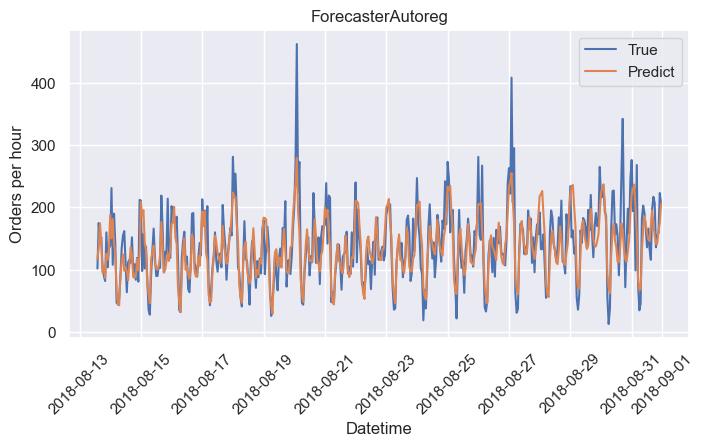

In [34]:
# тестирование лучшей модели
dummy = DummyRegressor()
dummy.fit(X_train, y_train)

test_model(best_model, dummy, X_test, y_test)

На тесте модель удовлетворяет условию RMSE < 48.

# Вывод

В процессе выполнения работы мы создали дополнительные признаки для обучения моделей, провели анализ целевого признака, выявили основные тренды и "сезонные" закономерности, обучили четыре модели: `LinearRegression`, `Ridge`, `Stacking` с `Ridge` и `LGBM`, `Forecaster` со стэкингом. После обучения была выбрана лучшая модель по значению RMSE на кросс валидации, которая затем была протестирована и она показывает результат лучше, чем `DummyRegressor` и удовлетворяет требуемуму условию RMSE < 48.